In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

# Chapter 4: Traning Models

- *Why understand the math behind machine learnings models?* (Q)
    - Quickly hone in on appropriate algorithms, or discard inappropriate ones
    - Easily narrow down the search space of hyperparameters
    - UNderstand debugging and model analysis

# Linear Regression

- Linear Regression is a conceptually simple model that predicts by computing a weighted sum of the input features, plus offset
    - $\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n $
    - Or, more compactly, $\hat{y} = h_\theta(\mathbf{x}) = \pmb{\theta} \cdot \pmb{x} = \pmb{\theta}^\intercal \pmb{x} $
        - 1st feature in the $\pmb{x}$ vector is always 1, to create the offset
        - $h_\theta(\pmb{x})$ is the hypothesis function, which describes the target as a function of the features
        - The value of $ \pmb{\theta} $ that minimizes the RMSE gives the model with best fit
        - In practice, it is easier to minimize the MSE instead of the RMSE.  This gives the same reuslt

- Mean Squared Error (MSE) is a measure of the average "miss" of the predictions from the ground truth:
$$ MSE(\pmb{X}, h_\theta) = \frac{1}{m} \sum_{i=1}^{m} (\pmb{\theta}^\intercal \pmb{x}_i - y_i )^{2} $$

- Root Mean Squared Error (RMSE) is simply the square root of the MSE:
$$ RMSE(\pmb{X}, h_\theta) = \sqrt{MSE(\pmb{X}, h_\theta)} $$

- *In what situation would you train a machine learning model with a different loss function than the function used to evaluate model performance?* (Q)
    - A different function might be easier/quicker to compute, such as using MSE instead of RMSE to fit a Linear Regression model
    - A different function might be easier to differentiate
    - In order to contrain the model, such as in a regularization setting

- The *Normal Equation* gives the closed-form solution to the optimization problem:
$$ \hat{\pmb{\theta}} = (\pmb{X}^\intercal \pmb{X})^{-1} \pmb{X}^\intercal \pmb{y} $$

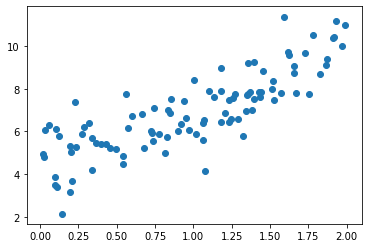

In [2]:
# An example
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)  # Normally distributed noise

plt.scatter(X, y);

In [3]:
# Compute the solution using the normal equation.
# This implementation calls out the fact that the solution
# is achieved with a chain of matrix multiplications

X_withbias = np.c_[np.ones(X.shape), X]
theta_hat = np.linalg.inv(X_withbias.T.dot(X_withbias)).dot(X_withbias.T).dot(y)  # Normal equation

In [25]:
# theta_hat is close to, but doens't precisely equal, the
# values hardcoded in the cell above.
theta_hat

array([[4.02684546],
       [2.93508926]])

In [21]:
X_new = np.array([[0], [2]])
X_new_withbias = np.c_[np.ones(X_new.shape), X_new]
y_pred = X_new_withbias.dot(theta_hat)

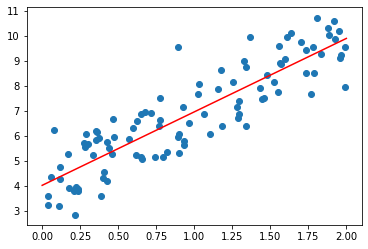

In [23]:
plt.scatter(X, y)
plt.plot(X_new, y_pred, color="red");

In [29]:
# Another example, this time using sklearn
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
# Again, the learned parameters approximate, but don't equal,
# the hardcoded values.
lin_reg.coef_, lin_reg.intercept_

(array([[2.93508926]]), array([4.02684546]))

In [32]:
# Finally, another example using numpy, which the sklearn
# implementation is based on.
theta_hat_svd, resid, rank, s = np.linalg.lstsq(X_withbias, y, rcond=1e-6)
theta_hat_svd

array([[4.02684546],
       [2.93508926]])

- The last example computes the Moore-Penrose (pseudo-)inverse of $\pmb{X}$:
    - $ \hat{\pmb{\theta}} = \pmb{X}^{+}\pmb{y} $
    - Can be computed directly with `np.linalg.pinv(X_withbias).dot(y)`
    - Moorse-Penrose inverse is calculated using SVD
        - $ \pmb{U} \pmb{\Sigma} \pmb{V}^\intercal $
        - `np.linalg.svd()`
        - Computed by taking SVD of $\pmb{X}$, set all small values in $\pmb{\Sigma}$ to zero, invert all its nonzero values, then transpose to get $ \pmb{U} \pmb{\Sigma}^{+} \pmb{V}^\intercal $
    - This is more efficient than copmuting the normal equation
    - More robust to cases where $ \pmb{X}^\intercal \pmb{X} $ cannot be inverted (i.e. it's singular)
        - Such as $n_{cols} > n_{rows}$ or in multicollinearity setting

- Computational complexity of the Moore-Penrose approach is better than the Normal Equation approach
    - Moore-Penrose approach used by `sklearn` is about $O(n^2)$
    - Inversion of an $(n+1) \times (n+1)$ matrix as in the normal equation is about $O(n^{2.4})$ to $O(n^3)$
    - Efficiency of both approaches deteriorates in high dimensions
    - Linear in the number of rows, so both approaches work well with large datasets
    - Predictions are fast once model has been trained: linear w.r.t. both number of features and rows

## Gradient Descent

- In addition to the analytic method described above, a gradient descent-based method can be used
- Gradient descent is a generic algorithm that can be used to find an optimum solution to many problems
- The idea is to iteratively update model parameters in such a way that the loss is progressively minimized
- Step size, i.e. learning rate, is an important parameter in the algorithm
    - Too-large step size can cause the algorithm to diverge
    - Too-small step size lengthens the time needed to converge
    - In practice, learning rate is progressively decreased to better "hone in" on an optimum

- Gradient descent can't be guaranteed to find the global minimum in a complex loss landscape
- However, if the loss function is convex, Gradient Descent will converge (given a not-too-large learning rate)

- Gradient descent benefits from features being scaled, otherwise it can take longer to converge

- To implement the Gradient Descent algorithmL
    - Compute the gradient of the cost function w.r.t. each parameter $\theta_j$
        - In the linear regrerssion example, this is $$ \frac{\partial}{\partial \theta_j}MSE(\pmb{\theta}) = \frac{2}{m}\sum_{i=1}^{m} (\pmb{\theta}^\intercal \pmb{x}_i - y_i)x_{ij} $$
        - This can be computed in one go: $$ \nabla_{\theta}MSE(\pmb{\theta}) = \frac{2}{m}\pmb{X}^\intercal(\pmb{X}\pmb{\theta} - \pmb{y}) $$
        - The gradient is a vector of partial derivatives, with length equal to the number of model parameters
        - Note that this requires computing the gradient over the _entire_ training set at each step in teh descent.  This is not very efficient, so there are modifications to the algorithm that give a speedup
        - Finally, compute the next step in terms of the previous step: $$ \pmb{\theta}_{next} = \pmb{\theta} = \eta\nabla_{\theta}MSE(\pmb{\theta}) $$

In [5]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_withbias.T.dot(X_withbias.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[4.27007324],
       [2.70548387]])

Finished numpy implementation on page 180